In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-05 09:45:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-05 09:45:36 (107 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



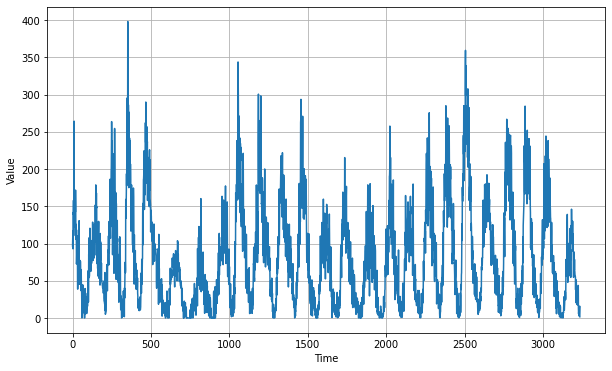

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

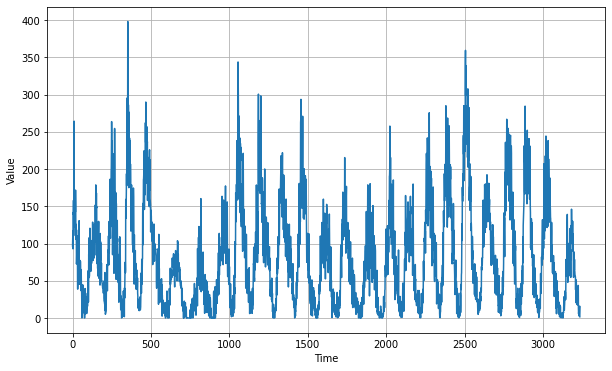

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 27ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 30ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 0s 35ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 0s 29ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 0s 26ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 0s 29ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 0s 34ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

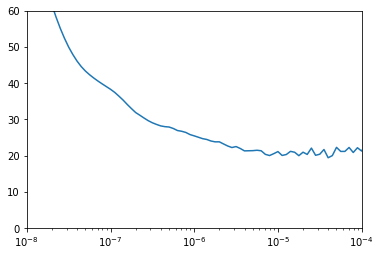

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 15ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 0s 15ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 0s 14ms/step - loss: 22.0767 - mae: 22.5705
Epoch 4/500
30/30 [==============================] - 0s 16ms/step - loss: 20.4707 - mae: 20.9637
Epoch 5/500
30/30 [==============================] - 0s 14ms/step - loss: 19.7904 - mae: 20.2829
Epoch 6/500
30/30 [==============================] - 0s 14ms/step - loss: 19.2760 - mae: 19.7682
Epoch 7/500
30/30 [==============================] - 0s 13ms/step - loss: 18.7040 - mae: 19.1962
Epoch 8/500
30/30 [==============================] - 0s 16ms/step - loss: 18.1201 - mae: 18.6117
Epoch 9/500
30/30 [==============================] - 0s 15ms/step - loss: 18.1580 - mae: 18.6496
Epoch 10/500
30/30 [==============================] - 0s 14ms/step - loss: 17.9761 - mae: 18.4673
Epoch 11/500
30/30 [=========

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

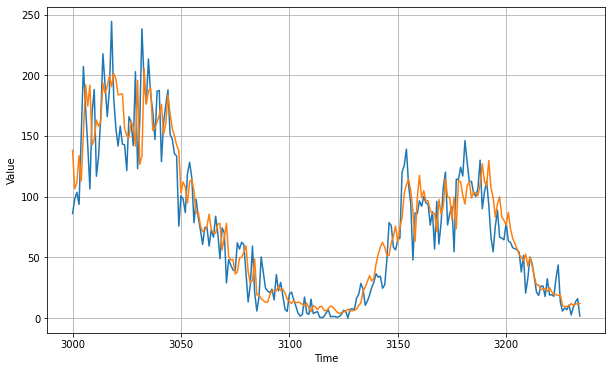

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.391739

<Figure size 432x288 with 0 Axes>

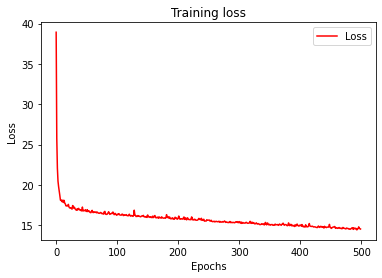

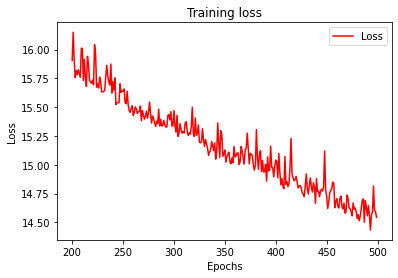

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[138.129     106.49533   111.60178   133.74876   112.77777   151.57564
 192.19699   174.65779   191.91133   142.4033    147.08818   163.06749
 157.81223   162.11856   193.46219   185.2533    190.86967   199.77325
 190.53894   201.46324   196.73904   183.75615   184.3292    184.54744
 156.22218   150.40619   148.31218   162.0273    157.17653   141.59256
 195.65228   126.612236  133.34447   205.75041   176.24199   187.07243
 189.34985   154.56387   156.4366    161.56041   167.27333   176.01859
 151.3263    160.3415    183.69753   167.93707   156.02504   150.04228
 142.38104   137.99338   102.91746   112.09643   107.92755    94.707275
 112.256134  114.339325  104.30533    86.241684   86.94755    75.8631
  71.33565    72.30327    75.733826   85.49338    72.6135     70.164406
  69.77789    77.36766    77.78083    56.057907   66.6631     77.914764
  50.92672    47.69469    48.256268   36.286606   37.829994   49.41005
  50.00696    54.107273   59.41707    38.407284   28.854475   30.651442
  4